In [23]:
import urllib
response = urllib.urlopen('http://deeplearning.net/tutorial/code/utils.py')
content = response.read()
target = open('utils.py', 'w')
target.write(content)
target.close()

In [24]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
from PIL import Image
from utils import tile_raster_images
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [42]:
hidden_layer_size = 100

vb = tf.placeholder("float", [784])
hb = tf.placeholder("float", [hidden_layer_size])

In [43]:
W = tf.placeholder("float", [784, hidden_layer_size])

In [44]:
X = tf.placeholder("float", [None, 784])
_h0 = tf.nn.sigmoid(tf.matmul(X, W) + hb)
h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0))))

In [45]:
# Detour example of sampling
with tf.Session() as sess:
    a = tf.constant([0.7,0.1,0.8,0.2])
    print sess.run(a)
    b = sess.run(tf.random_uniform(tf.shape(a)))
    print sess.run(a - b)
    print sess.run(tf.sign(a - b))
    print sess.run(tf.nn.relu(tf.sign(a - b)))

[ 0.69999999  0.1         0.80000001  0.2       ]
[ 0.69430393 -0.80116463  0.41452068  0.0377142 ]
[ 1. -1.  1.  1.]
[ 1.  0.  1.  1.]


In [46]:
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb)
v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)

In [47]:
alpha = 1.0
w_pos_grad = tf.matmul(tf.transpose(X), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)
CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(X[0]))
update_w = W + alpha * CD
update_vb = vb + alpha * tf.reduce_mean(X - v1, 0)
update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)

In [48]:
err = tf.reduce_mean(tf.square(X - v1))

In [49]:
cur_w = np.zeros([784, hidden_layer_size], np.float32)
cur_vb = np.zeros([784], np.float32)
cur_hb = np.zeros([hidden_layer_size], np.float32)
prv_w = np.zeros([784, hidden_layer_size], np.float32)
prv_vb = np.zeros([784], np.float32)
prv_hb = np.zeros([hidden_layer_size], np.float32)
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [50]:
sess.run(err, feed_dict={X: trX, W: prv_w, vb: prv_vb, hb: prv_hb})

0.48148492

Epoch: 0 reconstruction error: 0.076025
Epoch: 1 reconstruction error: 0.064512
Epoch: 2 reconstruction error: 0.059842
Epoch: 3 reconstruction error: 0.057056
Epoch: 4 reconstruction error: 0.055251


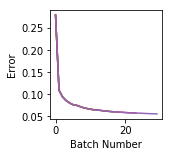

In [51]:
epochs = 5
batchsize = 100
weights = []
errors = []

for epoch in range(epochs):
    for start, end in zip(range(0, len(trX), batchsize), range(batchsize, len(trX), batchsize)):
        batch = trX[start:end]
        cur_w = sess.run(update_w, feed_dict={ X: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={  X: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_hb = sess.run(update_hb, feed_dict={ X: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb
        if start % 10000 == 0:
            errors.append(sess.run(err, feed_dict={X: trX, W: cur_w, vb: cur_vb, hb: cur_hb}))
            weights.append(cur_w)
    print 'Epoch: %d' % epoch,'reconstruction error: %f' % errors[-1]

    plt.plot(errors)
plt.xlabel("Batch Number")
plt.ylabel("Error")
plt.show()        

In [52]:
uw = weights[-1].T
uw

array([[-0.15868548, -0.16034757, -0.14946593, ..., -0.14777048,
        -0.15787077, -0.15213199],
       [-0.1343043 , -0.12461311, -0.14586355, ..., -0.13308385,
        -0.15129116, -0.12505955],
       [-0.14444494, -0.13077788, -0.14421828, ..., -0.12569228,
        -0.144225  , -0.12970704],
       ..., 
       [-0.13012074, -0.11718141, -0.13661498, ..., -0.12143517,
        -0.12124907, -0.11481152],
       [-0.15143788, -0.15873577, -0.15544115, ..., -0.13866371,
        -0.155084  , -0.1476505 ],
       [-0.12360641, -0.12255356, -0.13175218, ..., -0.12044412,
        -0.12508084, -0.11975848]], dtype=float32)

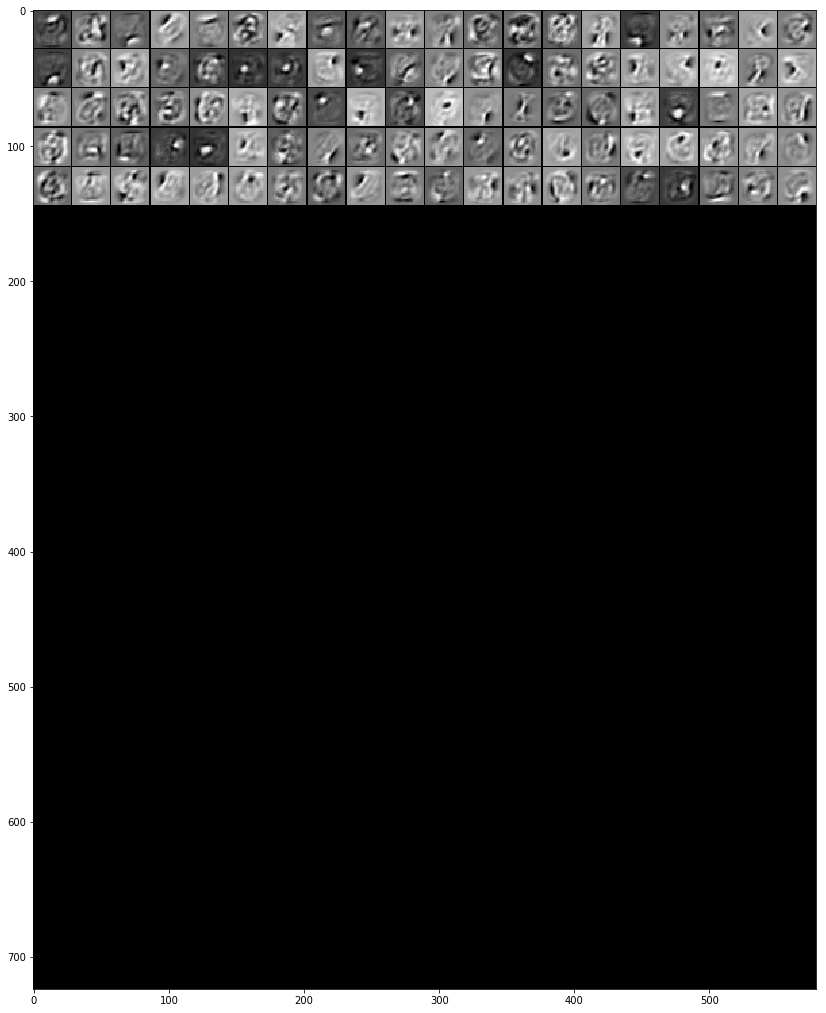

In [53]:
tile_raster_images(X=cur_w.T, img_shape=(28, 28), tile_shape=(25, 20), tile_spacing=(1, 1))
image = Image.fromarray(tile_raster_images(X=cur_w.T, img_shape=(28, 28) ,tile_shape=(25, 20), tile_spacing=(1, 1)))
plt.rcParams['figure.figsize'] = (18.0, 18.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')  

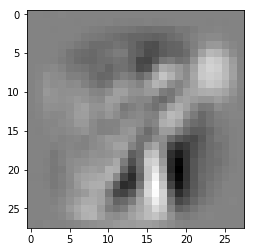

In [54]:
image = Image.fromarray(tile_raster_images(X=cur_w.T[10:11], img_shape=(28, 28),tile_shape=(1, 1), tile_spacing=(1, 1)))
plt.rcParams['figure.figsize'] = (4.0, 4.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')  

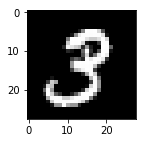

In [55]:
sample_case = trX[1:2]
img = Image.fromarray(tile_raster_images(X=sample_case, img_shape=(28, 28),tile_shape=(1, 1), tile_spacing=(1, 1)))
plt.rcParams['figure.figsize'] = (2.0, 2.0)
imgplot = plt.imshow(img)
imgplot.set_cmap('gray')

In [56]:
hh0 = tf.nn.sigmoid(tf.matmul(X, W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
feed = sess.run(hh0, feed_dict={ X: sample_case, W: prv_w, hb: prv_hb})
rec = sess.run(vv1, feed_dict={ hh0: feed, W: prv_w, vb: prv_vb})

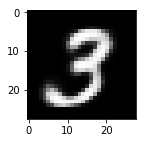

In [57]:
img = Image.fromarray(tile_raster_images(X=rec, img_shape=(28, 28),tile_shape=(1, 1), tile_spacing=(1, 1)))
plt.rcParams['figure.figsize'] = (2.0, 2.0)
imgplot = plt.imshow(img)
imgplot.set_cmap('gray') 